## Apple Health Processor

-----

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
#Backlog
#add vertical lines to mark surgery & novo start dates

#process workout data & calories burned
#ideally create single merged data table of daily fitness stats

------

## Steps

In [3]:
steps = pd.read_csv("data/StepCount.csv")
# steps.tail()

### Correct time zone to EST and capture time properties

In [4]:
# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['year_month'] = steps['startDate'].dt.strftime('%Y-%m')
steps['year'] = steps['startDate'].dt.year
steps['month'] = steps['startDate'].dt.month
steps['day'] = steps['startDate'].dt.day
steps['hour'] = steps['startDate'].dt.hour
steps['dow'] = steps['startDate'].dt.weekday
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate'], axis=1)
# steps.head()

### Use Only Watch Steps, Remove Phone Steps

In [5]:
# drop phone steps
steps = steps[steps.sourceName == 'Greg’s Apple\xa0Watch']
# steps.tail()

### Merge Fitbit data

In [6]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
fb['year'] = fb['Date'].dt.year
fb['month'] = fb['Date'].dt.month
fb['day'] = fb['Date'].dt.day
fb['dow'] = fb['Date'].dt.weekday
fb['doy'] = fb['Date'].dt.dayofyear

# #drop irrelevant columns
# fb = fb.drop(['Date', 'Calories Burned', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active','Activity Calories'], axis=1)

fb2=fb[['date', 'Steps']]
#drop rows that overlap apple watch
fb2=fb2.iloc[:-2,:]

# fb.head()
# fb2.tail()

-----

## Merge Fitbit Data

In [7]:
# Aggregate apple watch data by date
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_date = pd.concat([fb2, steps_by_date], ignore_index=True)

# print(steps_by_date.head())
print(steps_by_date.tail())

            date  Steps
1257  2020-04-12   6458
1258  2020-04-13   7622
1259  2020-04-14  16982
1260  2020-04-15   4988
1261  2020-04-16  12713


### Rolling average

In [8]:
steps_by_date2=steps_by_date.copy()
steps_by_date2['RollingMeanSteps'] = steps_by_date2.Steps.rolling(window=7, center=True).mean()

steps_by_date2=steps_by_date2.dropna(axis=0)
steps_by_date2['date']=pd.to_datetime(steps_by_date2['date'])

steps_by_date2=steps_by_date2.set_index('date')

print(steps_by_date2.head())

            Steps  RollingMeanSteps
date                               
2016-11-04  12480      12579.285714
2016-11-05  18186      13410.714286
2016-11-06  12595      13182.000000
2016-11-07  10742      12071.428571
2016-11-08  10252      11699.000000


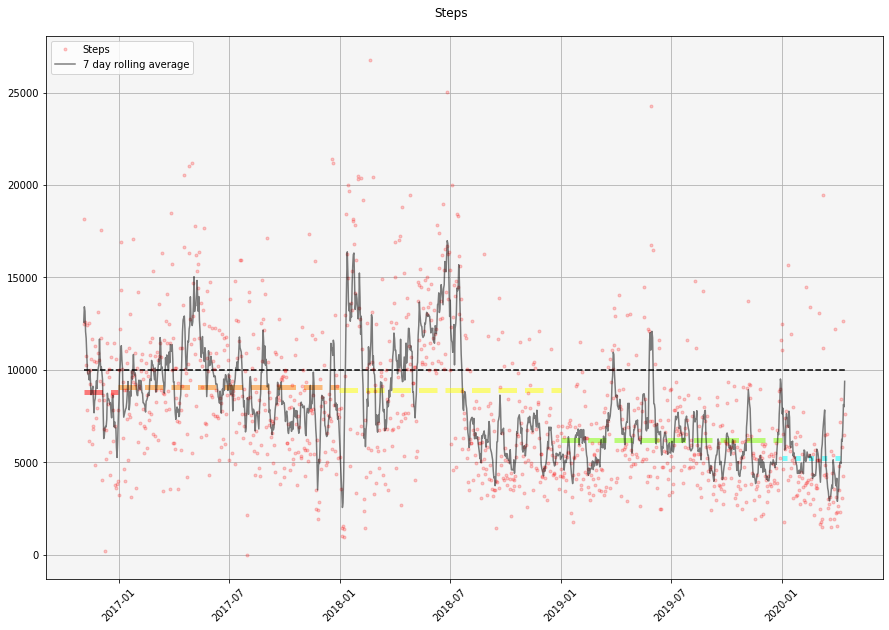

In [9]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2['RollingMeanSteps'], c='k',label='7 day rolling average', alpha=0.5)
plt.hlines(10000,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed')

plt.hlines(steps_by_date2.resample('Y').mean().iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean().index[0], linestyles='dashed', colors=(1,0,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[1,0],steps_by_date2.resample('Y').mean().index[0], steps_by_date2.resample('Y').mean().index[1], linestyles='dashed', colors=(1,0.5,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[2,0],steps_by_date2.resample('Y').mean().index[1], steps_by_date2.resample('Y').mean().index[2], linestyles='dashed', colors=(1,1,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[3,0],steps_by_date2.resample('Y').mean().index[2], steps_by_date2.resample('Y').mean().index[3], linestyles='dashed', colors=(0.5,1,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[4,0],steps_by_date2.resample('Y').mean().index[3], steps_by_date2.index.max(), linestyles='dotted', colors=(0,1,1,0.5), linewidths=(5,))

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

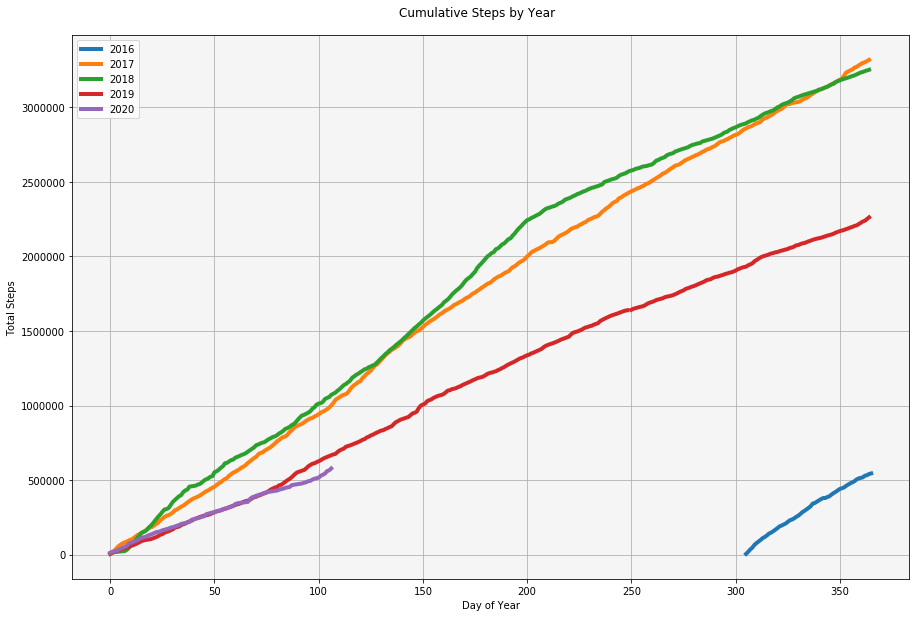

In [10]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)

plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

In [11]:
### Steps needed to get on track

#Yearly averages
yearly_totals=steps_by_date2['Steps'].resample('Y').sum()

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

print("I am currently averaging", math.ceil(yearly_totals.iloc[-1]/doy), "steps per day for", yearly_totals.index[-1].year)
print("To reach 10,000 steps per day I will need to walk", math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[1].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[2].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[3].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")

I am currently averaging 5076 steps per day for 2020
To reach 10,000 steps per day I will need to walk 12041 steps per day for the rest of the year.
To beat my 2017 steps I will need to walk 10748 steps per day for the rest of the year.
To beat my 2018 steps I will need to walk 10493 steps per day for the rest of the year.
To beat my 2019 steps I will need to walk 6658 steps per day for the rest of the year.


In [12]:
# #Write df to csv
# steps_by_date.to_csv("data/steps_per_day.csv", index=False)

------

## Monthly Steps

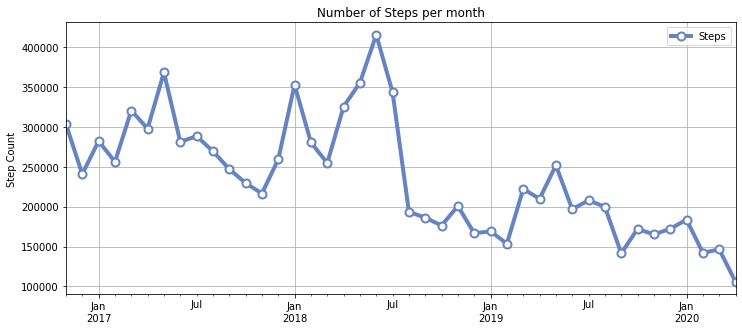

In [13]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df=df.set_index('date')
df = df.resample('M').sum()
# df.head()

chart_title = 'Number of Steps per month'

ax = df.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()

## Steps By Year

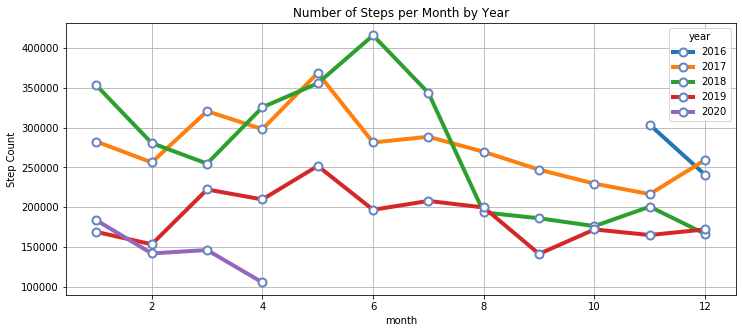

In [14]:
# Group data by year in pivot table
df2 = steps_by_date.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

plt.show()

----

-----

## Weight Data

In [15]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

# drop duplicates
weight.drop_duplicates(subset = 'date', keep='last', ignore_index=True, inplace=True)

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [16]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [17]:
#merge with fitbit data
# print(weight.shape)
weight = pd.concat([weight2,weight], ignore_index=True)
# print(weight.shape)
# weight.tail()

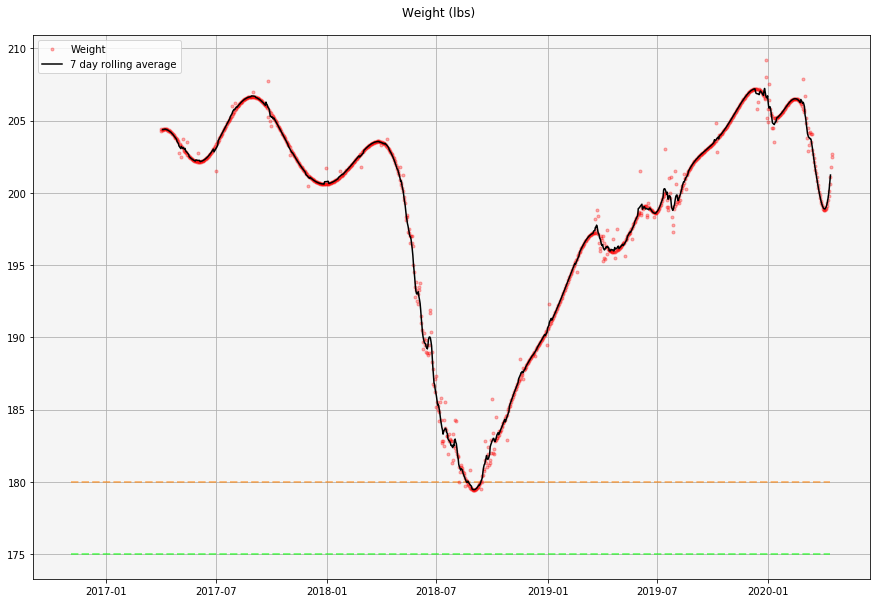

In [18]:
# parse out date and time elements
weight3 =weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight3 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)
# print(weight3.shape)

#create a 7day rolling average
weight3['rolling_avg']=weight3.rolling(window=7, center=True).mean()

#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight3['rolling_avg'], c='k',label='7 day rolling average')

plt.hlines(180,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(1,.5,0,0.5), linewidths=(2,))
plt.hlines(175,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(0,1,0,0.5), linewidths=(2,))

plt.legend(loc=2)

plt.show()

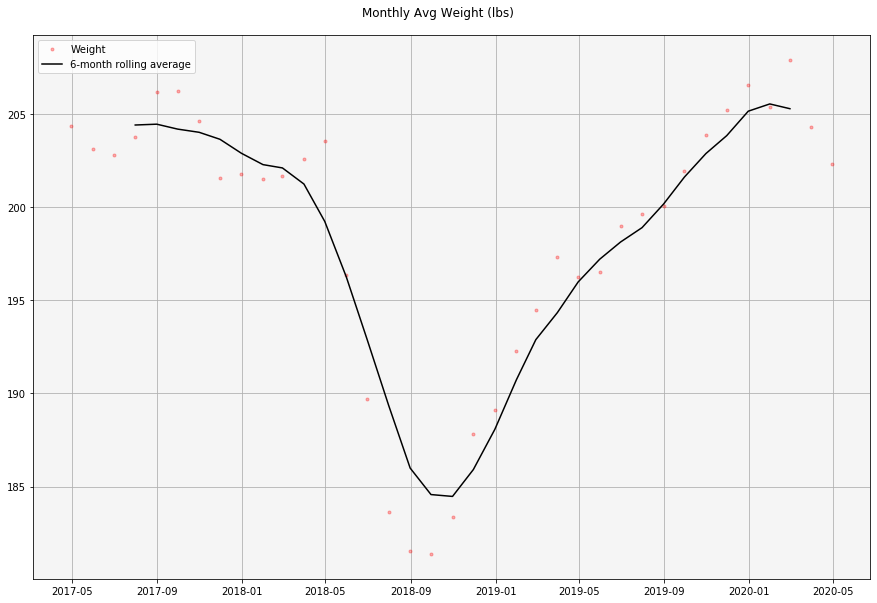

In [19]:
# parse out date and time elements
weight2 =weight.copy()
weight2['Date'] = pd.to_datetime(weight2['date'])

#sort by date and reindex
weight2 = weight2.sort_values(by='Date', ignore_index=True)

#set Date as index
weight2 = weight2.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight2 = weight2.resample('M').mean().interpolate(method='linear', axis = 0)
# print(weight2.shape)

#create a 6-month rolling average
weight2['rolling_avg']=weight2.rolling(window=6, center=True).mean()

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Monthly Avg Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight2['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight2['rolling_avg'], c='k',label='6-month rolling average')
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

## Heart Rate

----

### Resting Heart Rate

In [20]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# print(resting.head())

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
# resting = resting.drop(['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate'], axis=1)
resting = resting[['date', 'value']]

print(resting.head())

         date  value
0  2018-06-17     59
1  2018-06-18     53
2  2018-06-19     57
3  2018-06-21     54
4  2018-06-20     57


In [21]:
#Creating daily average resting HR
resting_daily = resting.copy()
resting_daily = resting_daily.sort_values('date', ignore_index=True)
resting_daily = resting_daily.groupby(['date'])['value'].mean().reset_index(name='Resting_HR')
resting_daily['date'] = pd.to_datetime(resting_daily['date'])
resting_daily = resting_daily.set_index('date')
 
resting_daily = resting_daily.resample('D').interpolate(method='spline', order = 4, axis = 0)

print(resting_daily.head())

            Resting_HR
date                  
2018-06-17        59.0
2018-06-18        53.0
2018-06-19        57.0
2018-06-20        57.0
2018-06-21        54.0


In [22]:
#Add rolling average
resting_daily2 = resting_daily.copy()
resting_daily2['RollingHR_7'] = resting_daily2.Resting_HR.rolling(window=7, center = True).mean()
resting_daily2['RollingHR_30'] = resting_daily2.Resting_HR.rolling(window=30, center = True).mean()

resting_daily2 = resting_daily2.dropna(axis=0)

print(resting_daily2.head())

            Resting_HR  RollingHR_7  RollingHR_30
date                                             
2018-07-02        54.0    54.428571     54.993935
2018-07-03        51.0    55.428571     54.793935
2018-07-04        54.0    54.928571     54.860602
2018-07-05        55.0    55.095441     54.793935
2018-07-06        62.0    56.524012     54.693935


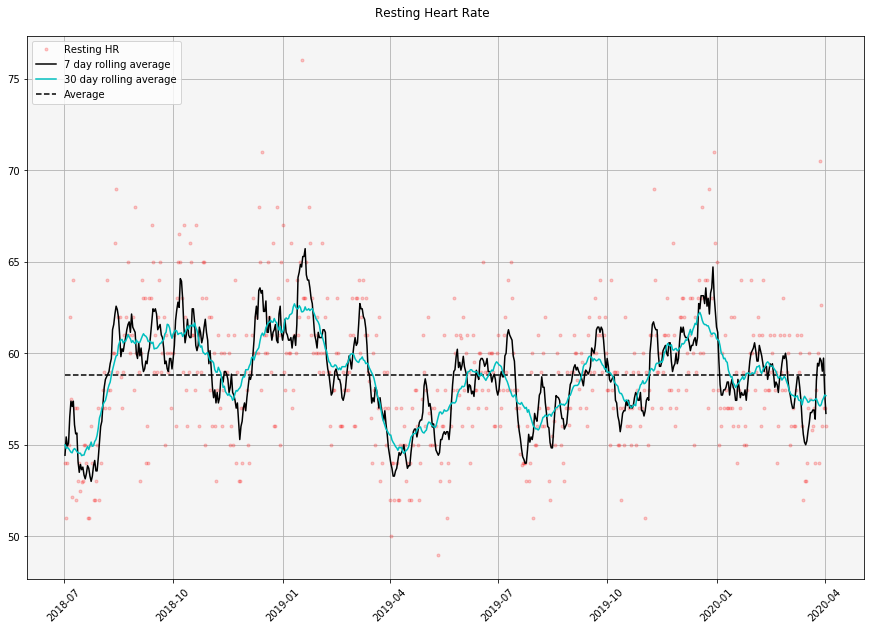

In [23]:
#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Resting Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(resting_daily2['Resting_HR'], 'r.', alpha=0.2,label='Resting HR')
plt.plot(resting_daily2['RollingHR_7'], c='k',label='7 day rolling average', alpha=1)
plt.plot(resting_daily2['RollingHR_30'], c='c',label='30 day rolling average', alpha=1)
plt.hlines(resting_daily2['Resting_HR'].mean(),resting_daily2.index.min(), resting_daily2.index.max(), label = 'Average', linestyles='dashed')

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

### Heart Rate

In [24]:
hr = pd.read_csv("data/HeartRate.csv")

# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
# hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
hr = hr[['startDate', 'value']]

# hr.head()
# hr.tail()

151343
           sourceName sourceVersion  \
0  Greg’s Apple Watch           4.3   
1  Greg’s Apple Watch           4.3   
2  Greg’s Apple Watch           4.3   
3  Greg’s Apple Watch           4.3   
4  Greg’s Apple Watch           4.3   

                                              device       type       unit  \
0  <<HKDevice: 0x2827c5630>, name:Apple Watch, ma...  HeartRate  count/min   
1  <<HKDevice: 0x2827c7cf0>, name:Apple Watch, ma...  HeartRate  count/min   
2  <<HKDevice: 0x2827c4730>, name:Apple Watch, ma...  HeartRate  count/min   
3  <<HKDevice: 0x2827c68f0>, name:Apple Watch, ma...  HeartRate  count/min   
4  <<HKDevice: 0x2827c6710>, name:Apple Watch, ma...  HeartRate  count/min   

                creationDate                  startDate  \
0  2018-06-17 16:05:18 -0400  2018-06-17 16:02:25 -0400   
1  2018-06-17 16:10:33 -0400  2018-06-17 16:06:56 -0400   
2  2018-06-17 16:15:28 -0400  2018-06-17 16:11:30 -0400   
3  2018-06-17 16:20:33 -0400  2018-06-17 16:19:07 -04

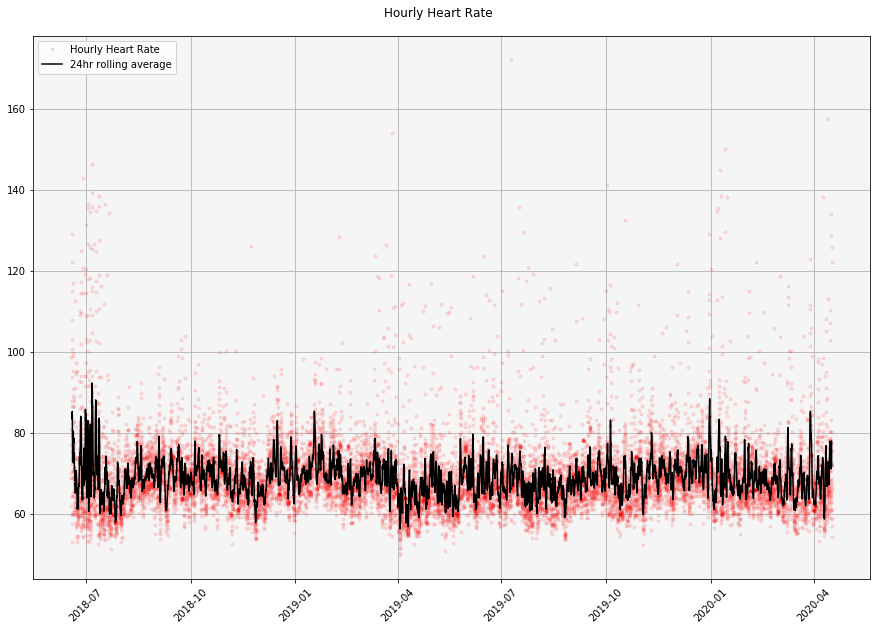

In [25]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('H').mean()
hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=24, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Hourly Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Hourly Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='24hr rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

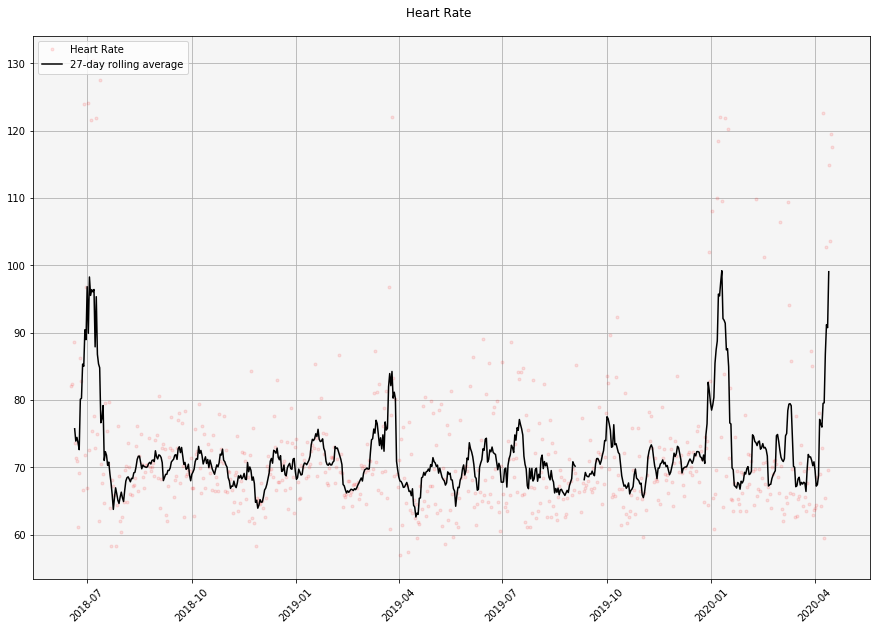

In [26]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('D').mean()
# hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=7, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='27-day rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

------